In [3]:
# Cell 1: Imports and Helper Functions
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hed
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz

def read_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return (mask > 127).astype(np.uint8)  # binary mask

def extract_he_channels(rgb_img):
    hed = rgb2hed(rgb_img)
    H = hed[:, :, 0]
    E = hed[:, :, 1]
    H_img = np.uint8(255 * (H - H.min()) / (H.max() - H.min()))
    E_img = np.uint8(255 * (E - E.min()) / (E.max() - E.min()))
    return H_img, E_img

def cluster_pixels(features, method='kmeans', n_clusters=2):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
        labels = model.labels_
    elif method == 'gmm':
        model = GaussianMixture(n_components=n_clusters, random_state=0).fit(features)
        labels = model.predict(features)
    elif method == 'fcm':
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            features.T, c=n_clusters, m=2, error=0.005, maxiter=1000)
        labels = np.argmax(u, axis=0)
    else:
        raise ValueError('Invalid method')
    return labels

def label_nuclei(mask, img):
    cluster0_mean = img[mask == 0].mean()
    cluster1_mean = img[mask == 1].mean()
    if cluster0_mean < cluster1_mean:
        nuclei_mask = (mask == 0).astype(np.uint8)
    else:
        nuclei_mask = (mask == 1).astype(np.uint8)
    return nuclei_mask

def consensus_mask(masks):
    sum_mask = np.sum(masks, axis=0)
    consensus = (sum_mask >= (len(masks) / 2)).astype(np.uint8)
    return consensus

def compute_metrics(pred_mask, gt_mask):
    TP = np.sum((pred_mask == 1) & (gt_mask == 1))
    TN = np.sum((pred_mask == 0) & (gt_mask == 0))
    FP = np.sum((pred_mask == 1) & (gt_mask == 0))
    return TP, TN, FP

def save_img(img, path):
    if len(img.shape) == 2:
        cv2.imwrite(path, img)
    else:
        cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


In [4]:
# Cell 2: Main Processing Function

def process_single_image(image_path, mask_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Load image and GT mask
    img_rgb = read_image(image_path)
    gt_mask = read_mask(mask_path)
    print(f"Loaded image: {image_path}")
    print(f"Loaded GT mask: {mask_path}")

    # Extract H and E channels
    H_img, E_img = extract_he_channels(img_rgb)
    save_img(H_img, os.path.join(output_dir, "H_channel.png"))
    save_img(E_img, os.path.join(output_dir, "E_channel.png"))

    # Prepare pixel features from H channel
    h_flat = H_img.flatten().reshape(-1, 1).astype(np.float32)

    # Cluster pixels
    kmeans_labels = cluster_pixels(h_flat, method='kmeans').reshape(H_img.shape)
    fcm_labels = cluster_pixels(h_flat, method='fcm').reshape(H_img.shape)
    gmm_labels = cluster_pixels(h_flat, method='gmm').reshape(H_img.shape)

    # Convert cluster labels to nuclei masks (assume cluster with lower intensity = nuclei)
    kmeans_nuclei = label_nuclei(kmeans_labels, H_img)
    fcm_nuclei = label_nuclei(fcm_labels, H_img)
    gmm_nuclei = label_nuclei(gmm_labels, H_img)

    # Save masks
    save_img(kmeans_nuclei * 255, os.path.join(output_dir, "kmeans_mask.png"))
    save_img(fcm_nuclei * 255, os.path.join(output_dir, "fcm_mask.png"))
    save_img(gmm_nuclei * 255, os.path.join(output_dir, "gmm_mask.png"))
    save_img(gt_mask * 255, os.path.join(output_dir, "gt_mask.png"))

    # Consensus mask (majority voting)
    masks_stack = np.stack([kmeans_nuclei, fcm_nuclei, gmm_nuclei])
    consensus = consensus_mask(masks_stack)
    save_img(consensus * 255, os.path.join(output_dir, "consensus_mask.png"))

    # Calculate pixel-level metrics
    TP, TN, FP = compute_metrics(consensus, gt_mask)
    print(f"Pixel-level metrics:\nTP: {TP}, TN: {TN}, FP: {FP}")

    # Visualization
    fig, axes = plt.subplots(1, 7, figsize=(28, 5))
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original RGB')
    axes[1].imshow(H_img, cmap='gray')
    axes[1].set_title('H channel')
    axes[2].imshow(E_img, cmap='gray')
    axes[2].set_title('E channel')
    axes[3].imshow(kmeans_nuclei, cmap='gray')
    axes[3].set_title('KMeans')
    axes[4].imshow(fcm_nuclei, cmap='gray')
    axes[4].set_title('FCM')
    axes[5].imshow(gmm_nuclei, cmap='gray')
    axes[5].set_title('GMM')

    overlay = img_rgb.copy()
    overlay[consensus == 1] = [255, 0, 0]  # red overlay for consensus nuclei
    axes[6].imshow(overlay)
    axes[6].set_title('Consensus Overlay')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Loaded image: TCGA-21-5784-01Z-00-DX1.tif
Loaded GT mask: gt_mask.png
Pixel-level metrics:
TP: 37562, TN: 43671, FP: 818679


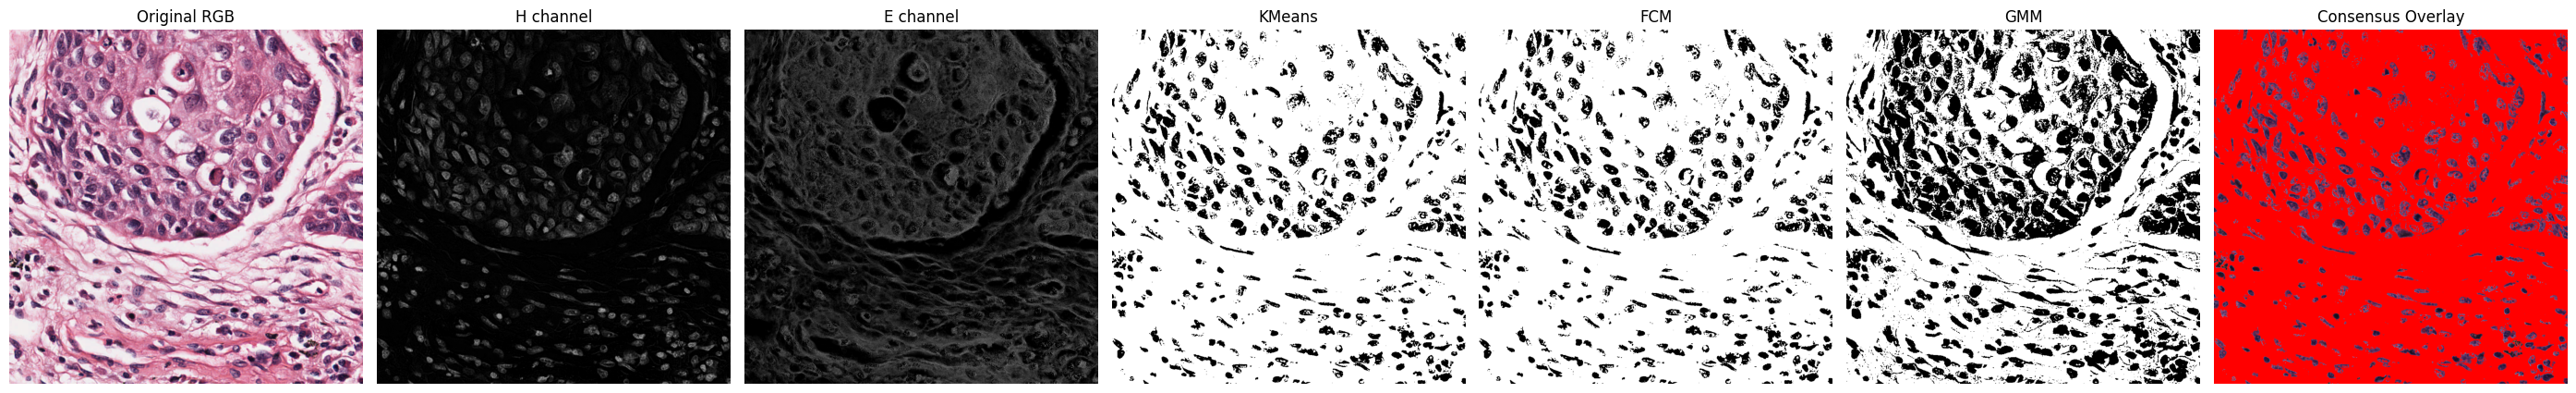

In [5]:
# Cell 3: Run the pipeline with your own paths

# Update these paths before running
image_path = "TCGA-21-5784-01Z-00-DX1.tif"
mask_path = "gt_mask.png"
output_dir = "stain/"

process_single_image(image_path, mask_path, output_dir)


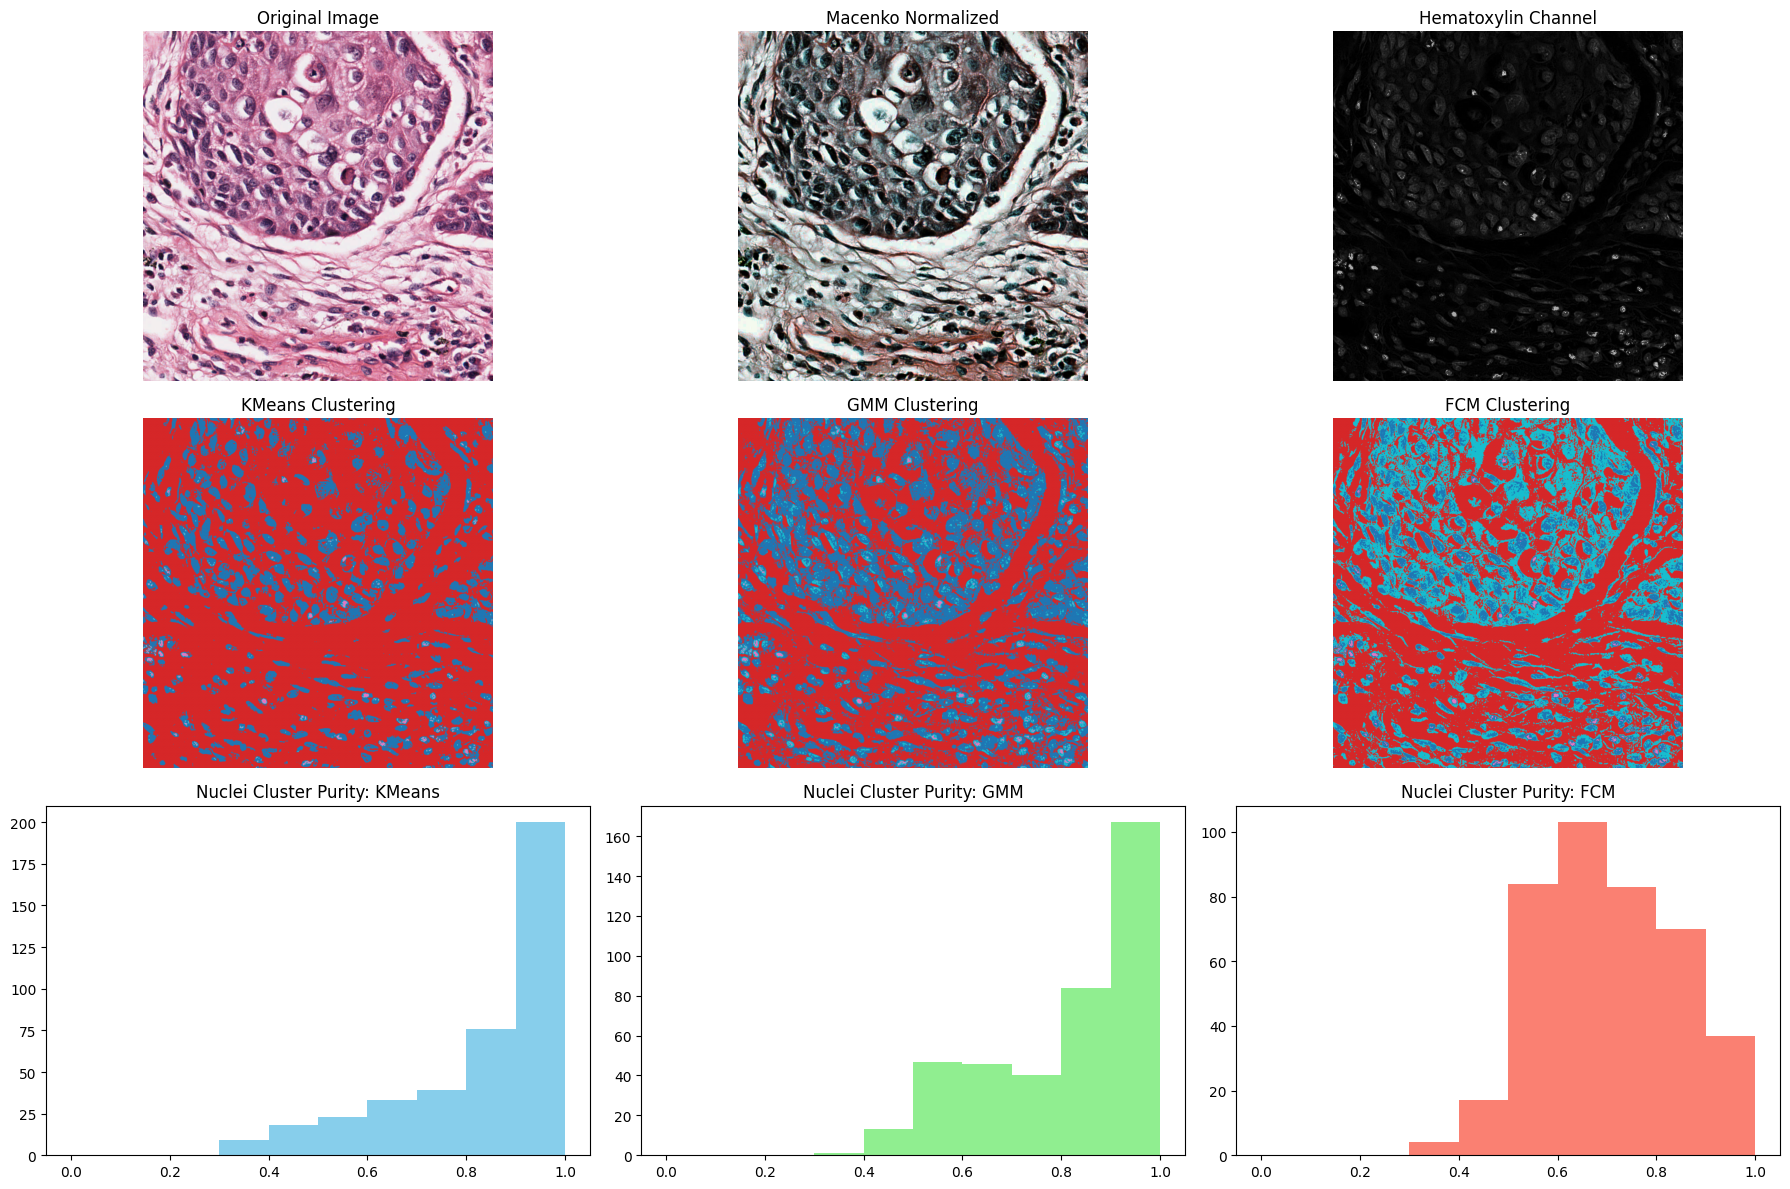

FileNotFoundError: [Errno 2] No such file or directory: 'phase2_kmeans_mask.npy'

In [2]:
# === PHASE 3: Nuclei-wise Feature Clustering and Evaluation ===

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from skimage.color import rgb2hed
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.filters import sobel
from skimage import exposure
from skfuzzy import cmeans
from collections import Counter

# === CONFIG ===
img_name = "TCGA-21-5784-01Z-00-DX1"
img_path = f"{img_name}.tif"
gt_mask_path = "gt_mask.png"
instance_mask_path = "instance_mask.png"
n_clusters = 4

# === Load Image and Masks ===
def load_image(path):
    img = tifffile.imread(path)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img[:, :, :3]

def load_mask(path):
    return np.array(Image.open(path))

image = load_image(img_path)
gt_mask = load_mask(gt_mask_path)
instance_mask = load_mask(instance_mask_path)

# === Step 1: Macenko Normalization (simplified) ===
def macenko_normalization(img):
    img = img.astype(np.float32) / 255.0
    img[:, :, 0] = exposure.equalize_hist(img[:, :, 0])
    img[:, :, 1] = exposure.equalize_hist(img[:, :, 1])
    img[:, :, 2] = exposure.equalize_hist(img[:, :, 2])
    return (img * 255).astype(np.uint8)

normalized_img = macenko_normalization(image)

# === Step 2: Extract H-stain (Hematoxylin) Channel ===
hed = rgb2hed(normalized_img / 255.0)
H_channel = hed[:, :, 0]

# === Step 3: Compute Sobel Edges for Texture ===
edges = sobel(H_channel)

# === Step 4: Feature Vector per Pixel ===
H_vec = H_channel.flatten()
edges_vec = edges.flatten()
features = np.stack([H_vec, edges_vec], axis=1)

# === Step 5: Apply Clustering ===
def cluster_kmeans(X, k):
    return KMeans(n_clusters=k, random_state=42).fit_predict(X)

def cluster_gmm(X, k):
    return GaussianMixture(n_components=k, random_state=42).fit_predict(X)

def cluster_fcm(X, k):
    data = X.T
    cntr, u, _, _, _, _, _ = cmeans(data, c=k, m=2, error=0.005, maxiter=1000)
    return np.argmax(u, axis=0)

H, W = H_channel.shape
kmeans_masked = cluster_kmeans(features, n_clusters).reshape(H, W)
gmm_masked = cluster_gmm(features, n_clusters).reshape(H, W)
fcm_masked = cluster_fcm(features, n_clusters).reshape(H, W)

# === Step 6: Dice Score Evaluation ===
def best_dice_per_cluster(pred_mask, gt_mask, n_clusters):
    dice_scores = []
    for i in range(1, n_clusters):
        pred = (pred_mask == i).astype(np.uint8)
        intersection = np.logical_and(pred, gt_mask).sum()
        dice = (2. * intersection) / (pred.sum() + gt_mask.sum() + 1e-8)
        dice_scores.append(dice)
    return dice_scores

dice_kmeans = best_dice_per_cluster(kmeans_masked, gt_mask, n_clusters)
dice_gmm = best_dice_per_cluster(gmm_masked, gt_mask, n_clusters)
dice_fcm = best_dice_per_cluster(fcm_masked, gt_mask, n_clusters)

# === Step 7: Nuclei-wise Cluster Purity ===
def cluster_purity_per_nucleus(cluster_map, instance_mask, min_size=10):
    instance_ids = np.unique(instance_mask)
    purities = []
    for inst_id in instance_ids:
        if inst_id == 0: continue
        coords = np.where(instance_mask == inst_id)
        if len(coords[0]) < min_size:
            continue
        cluster_labels = cluster_map[coords]
        label_counts = Counter(cluster_labels)
        dominant_label, count = label_counts.most_common(1)[0]
        purity = count / len(cluster_labels)
        purities.append(purity)
    return purities

purity_kmeans = cluster_purity_per_nucleus(kmeans_masked, instance_mask)
purity_gmm = cluster_purity_per_nucleus(gmm_masked, instance_mask)
purity_fcm = cluster_purity_per_nucleus(fcm_masked, instance_mask)

# === Step 8: Visualization ===
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

axs[0, 0].imshow(image)
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(normalized_img)
axs[0, 1].set_title("Macenko Normalized")

axs[0, 2].imshow(H_channel, cmap='gray')
axs[0, 2].set_title("Hematoxylin Channel")

axs[1, 0].imshow(kmeans_masked, cmap='tab10')
axs[1, 0].set_title("KMeans Clustering")
axs[1, 1].imshow(gmm_masked, cmap='tab10')
axs[1, 1].set_title("GMM Clustering")
axs[1, 2].imshow(fcm_masked, cmap='tab10')
axs[1, 2].set_title("FCM Clustering")

axs[2, 0].hist(purity_kmeans, bins=10, range=(0,1), color='skyblue')
axs[2, 0].set_title("Nuclei Cluster Purity: KMeans")
axs[2, 1].hist(purity_gmm, bins=10, range=(0,1), color='lightgreen')
axs[2, 1].set_title("Nuclei Cluster Purity: GMM")
axs[2, 2].hist(purity_fcm, bins=10, range=(0,1), color='salmon')
axs[2, 2].set_title("Nuclei Cluster Purity: FCM")

for ax in axs.flat:
    ax.axis('off') if ax.get_subplotspec().is_first_row() or "Purity" not in ax.get_title() else None

plt.tight_layout()
plt.show()

# === Step 9: Phase 2 vs Phase 3 Dice Comparison (Assuming saved) ===
phase2_kmeans = np.load("phase2_kmeans_mask.npy")
phase2_gmm = np.load("phase2_gmm_mask.npy")
phase2_fcm = np.load("phase2_fcm_mask.npy")

phase2_scores = {
    "KMeans": max(best_dice_per_cluster(phase2_kmeans, gt_mask, n_clusters)),
    "GMM": max(best_dice_per_cluster(phase2_gmm, gt_mask, n_clusters)),
    "FCM": max(best_dice_per_cluster(phase2_fcm, gt_mask, n_clusters))
}

phase3_scores = {
    "KMeans": max(dice_kmeans),
    "GMM": max(dice_gmm),
    "FCM": max(dice_fcm)
}

labels = list(phase2_scores.keys())
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, [phase2_scores[l] for l in labels], width, label="Phase 2", color="lightgray")
plt.bar(x + width/2, [phase3_scores[l] for l in labels], width, label="Phase 3", color="mediumseagreen")

plt.xticks(x, labels)
plt.ylabel("Dice Score")
plt.title("Phase 2 vs Phase 3 Dice Score Comparison")
plt.legend()
plt.tight_layout()
plt.show()


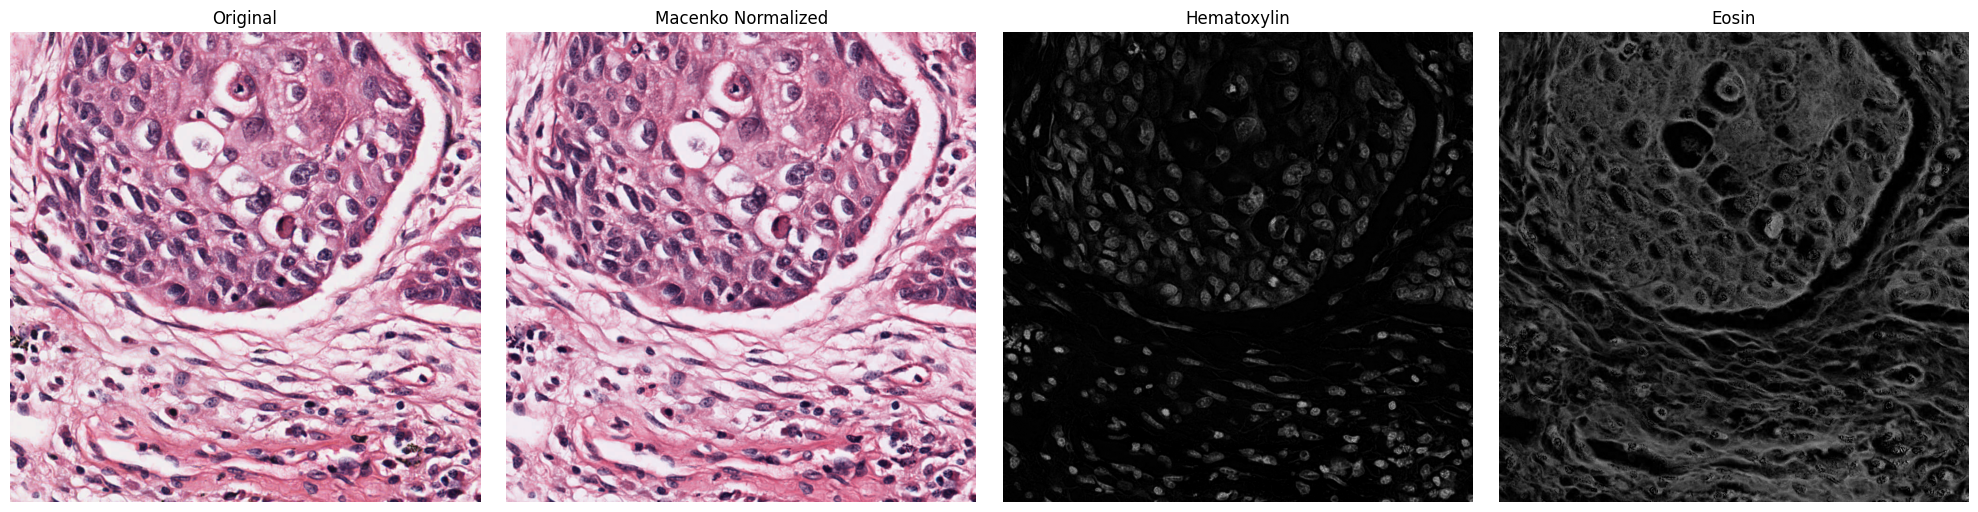

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity

# --- Macenko normalization helpers ---
def rgb_to_od(I):
    I = I.astype(np.float32)
    I[I == 0] = 1
    return -np.log((I + 1e-8) / 255)

def od_to_rgb(OD):
    I = 255 * np.exp(-OD)
    return np.clip(I, 0, 255).astype(np.uint8)

def normalize_rows(mat):
    return mat / np.linalg.norm(mat, axis=1, keepdims=True)

def get_stain_matrix_and_concentration(I, alpha=1, beta=0.15):
    OD = rgb_to_od(I).reshape((-1, 3))
    ODhat = OD[~np.any(OD < beta, axis=1)]
    _, _, V = np.linalg.svd(ODhat, full_matrices=False)
    V = V[:2, :]
    That = ODhat @ V.T
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    vMin = V.T @ [np.cos(minPhi), np.sin(minPhi)]
    vMax = V.T @ [np.cos(maxPhi), np.sin(maxPhi)]
    HE = np.array([vMax, vMin]).T if vMin[0] > vMax[0] else np.array([vMin, vMax]).T
    HE = normalize_rows(HE.T).T
    C = np.linalg.lstsq(HE, OD.T, rcond=None)[0]
    return HE, C

def macenko_normalize(I, HE_ref, maxC_ref):
    OD = rgb_to_od(I).reshape((-1, 3))
    C = np.linalg.lstsq(HE_ref, OD.T, rcond=None)[0]
    maxC = np.percentile(C, 99, axis=1)
    C_norm = C / maxC[:, None]
    C_scaled = C_norm * maxC_ref[:, None]
    OD_norm = HE_ref @ C_scaled
    OD_norm = OD_norm.T.reshape(I.shape)
    return od_to_rgb(OD_norm)

# --- Stain channel extraction ---
def extract_hematoxylin(image_np):
    hed = rgb2hed(image_np)
    hematoxylin = hed[:, :, 0]
    return rescale_intensity(hematoxylin, out_range=(0, 255)).astype(np.uint8)

def extract_eosin(image_np):
    hed = rgb2hed(image_np)
    eosin = hed[:, :, 1]
    return rescale_intensity(eosin, out_range=(0, 255)).astype(np.uint8)

# --- Image resize utility ---
def resize_image(image_path, max_size=(1024, 1024)):
    image = Image.open(image_path).convert("RGB")
    image.thumbnail(max_size)
    return image

# --- Output folders ---
os.makedirs("output_normalized", exist_ok=True)
os.makedirs("output_hematoxylin", exist_ok=True)
os.makedirs("output_eosin", exist_ok=True)

# --- Process a single image in the same folder ---
image_name = "TCGA-21-5784-01Z-00-DX1.tif"
patient_id = os.path.splitext(image_name)[0]

# Load and resize image
image = resize_image(image_name)
image_np = np.array(image)
original_image = image_np.copy()

# Macenko normalization reference
HE_ref, C_ref = get_stain_matrix_and_concentration(image_np)
maxC_ref = np.percentile(C_ref, 99, axis=1)

# Normalize
normalized_np = macenko_normalize(image_np, HE_ref, maxC_ref)

# Extract stain channels
hematoxylin_np = extract_hematoxylin(normalized_np)
eosin_np = extract_eosin(normalized_np)

# Save outputs
Image.fromarray(normalized_np).save(f"output_normalized/{patient_id}_normalized.tif")
Image.fromarray(hematoxylin_np).save(f"output_hematoxylin/{patient_id}_hematoxylin.png")
Image.fromarray(eosin_np).save(f"output_eosin/{patient_id}_eosin.png")

# --- Display results ---
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(original_image)
axs[0].set_title("Original")
axs[1].imshow(normalized_np)
axs[1].set_title("Macenko Normalized")
axs[2].imshow(hematoxylin_np, cmap='gray')
axs[2].set_title("Hematoxylin")
axs[3].imshow(eosin_np, cmap='gray')
axs[3].set_title("Eosin")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [9]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# === CONFIGURATION ===
image_id = "TCGA-21-5784-01Z-00-DX1"  # Replace with your desired image ID (filename prefix)
downsample_factor = 2  # Set to 1 for no downsampling

# Paths
output_hematoxylin = "output_hematoxylin"
output_eosin = "output_eosin"
output_features = "outputs/features"
os.makedirs(output_features, exist_ok=True)

# Load Hematoxylin and Eosin images (grayscale PNGs)
hematox_path = os.path.join(output_hematoxylin, f"{image_id}_hematoxylin.png")
eosin_path = os.path.join(output_eosin, f"{image_id}_eosin.png")

hematox_img = np.array(Image.open(hematox_path))
eosin_img = np.array(Image.open(eosin_path))

# === Feature Extraction Function ===
def extract_features(hematox_np, eosin_np, downsample_factor=1):
    hematox = hematox_np[::downsample_factor, ::downsample_factor]
    eosin = eosin_np[::downsample_factor, ::downsample_factor]

    H, W = hematox.shape
    x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))

    features = np.stack([
        x_coords.flatten(),
        y_coords.flatten(),
        hematox.flatten(),
        eosin.flatten()
    ], axis=1)
    return features

# Extract features
features = extract_features(hematox_img, eosin_img, downsample_factor=downsample_factor)

# Save to CSV
csv_path = os.path.join(output_features, f"{image_id}_features.csv")
df = pd.DataFrame(features, columns=["x", "y", "hematoxylin_intensity", "eosin_intensity"])
df.to_csv(csv_path, index=False)

# Save to NPY
npy_path = os.path.join(output_features, f"{image_id}_features.npy")
np.save(npy_path, features)

print(f"[Feature Extraction] Saved features for {image_id} -> CSV + NPY")


[Feature Extraction] Saved features for TCGA-21-5784-01Z-00-DX1 -> CSV + NPY


Saved features to: features_single_image/single_image_features.npy


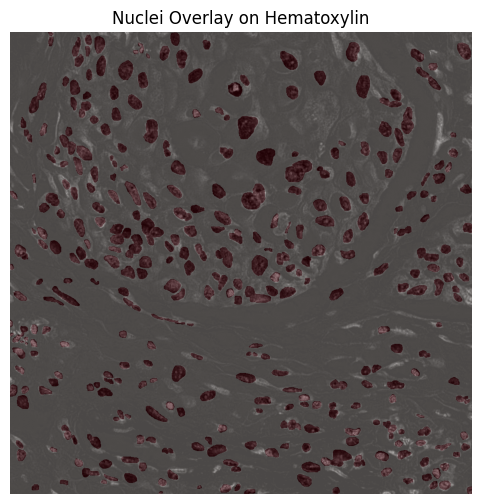

Saved visualization to: visualization_single_image/single_image_overlay.png


In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Paths (adjust filenames accordingly)
hematox_path = "output_hematoxylin/TCGA-21-5784-01Z-00-DX1_hematoxylin.png"  # Hematoxylin grayscale image
mask_path = "gt_mask.png"         # Binary nuclei mask (255 = nuclei)

# Output folders for features and visualization
output_features_dir = "features_single_image"
output_visual_dir = "visualization_single_image"
os.makedirs(output_features_dir, exist_ok=True)
os.makedirs(output_visual_dir, exist_ok=True)

def extract_nuclei_features(hematox_path, mask_path):
    # Load images
    hematox_np = np.array(Image.open(hematox_path))
    mask_np = np.array(Image.open(mask_path))

    # Find nuclei pixels (mask == 255)
    nuclei_pixels = (mask_np == 255)
    if np.sum(nuclei_pixels) == 0:
        print("No nuclei pixels found in the mask!")
        return None, hematox_np, mask_np

    height, width = hematox_np.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

    # Filter only nuclei pixels
    x_filtered = x_coords[nuclei_pixels]
    y_filtered = y_coords[nuclei_pixels]
    intensity_filtered = hematox_np[nuclei_pixels]

    # Stack features: x, y, hematoxylin intensity
    features = np.stack([x_filtered, y_filtered, intensity_filtered], axis=1)
    return features, hematox_np, mask_np

# Extract features
features, hematox_np, mask_np = extract_nuclei_features(hematox_path, mask_path)

if features is not None:
    # Save features as numpy array
    feature_file = os.path.join(output_features_dir, "single_image_features.npy")
    np.save(feature_file, features)
    print(f"Saved features to: {feature_file}")

    # Visualization: overlay nuclei mask on hematoxylin image
    plt.figure(figsize=(6, 6))
    plt.imshow(hematox_np, cmap='gray')
    plt.imshow(mask_np, cmap='Reds', alpha=0.3)
    plt.title("Nuclei Overlay on Hematoxylin")
    plt.axis('off')

    vis_file = os.path.join(output_visual_dir, "single_image_overlay.png")
    plt.savefig(vis_file, bbox_inches='tight', pad_inches=0.1, dpi=150)
    plt.show()
    print(f"Saved visualization to: {vis_file}")
else:
    print("Feature extraction failed.")


Detected 331 nuclei instances (excluding background)


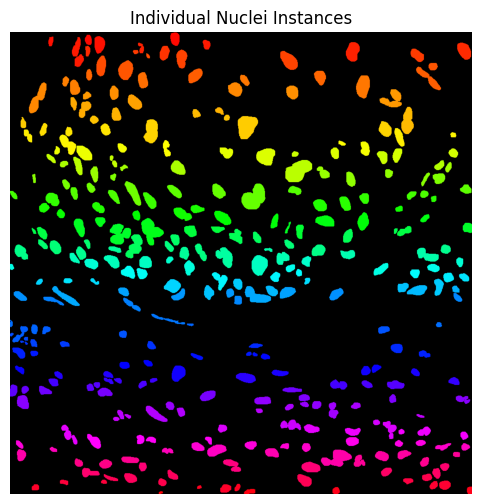

/tmp/ipykernel_15440/1523443670.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', n_clusters)


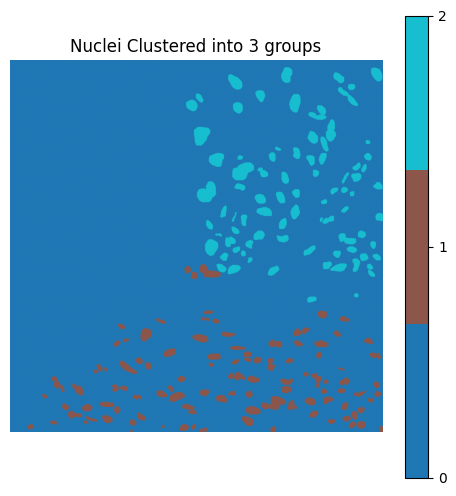

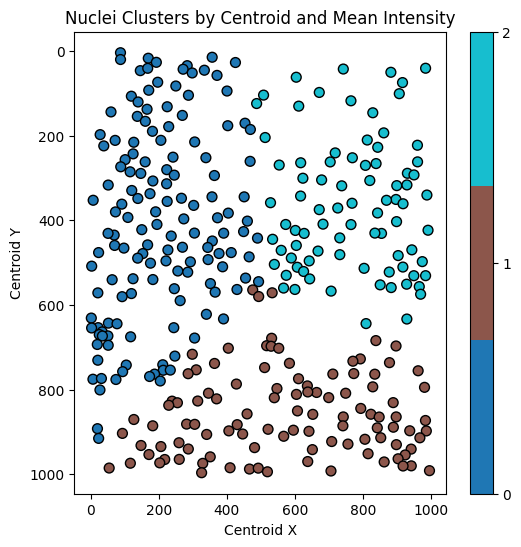

In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

hematox_path = "output_hematoxylin/TCGA-21-5784-01Z-00-DX1_hematoxylin.png"  # Your hematoxylin image
mask_path = "gt_mask.png"  # Your binary nuclei mask for that image


# --- Load images ---
hematox_np = np.array(Image.open(hematox_path))
mask_np = np.array(Image.open(mask_path))

# Convert mask to binary (0 and 1)
binary_mask = (mask_np == 255).astype(np.uint8)

# --- Segment individual nuclei ---
num_labels, labels_im = cv2.connectedComponents(binary_mask)
print(f"Detected {num_labels-1} nuclei instances (excluding background)")

# --- Extract per-nucleus features ---
features = []
for label in range(1, num_labels):  # Skip background 0
    nucleus_mask = (labels_im == label)

    # Mean intensity in hematoxylin channel
    mean_intensity = hematox_np[nucleus_mask].mean()

    # Centroid coordinates (x, y)
    coords = np.column_stack(np.where(nucleus_mask))
    centroid_yx = coords.mean(axis=0)  # (row, col) = (y, x)
    centroid_x, centroid_y = centroid_yx[1], centroid_yx[0]

    features.append([centroid_x, centroid_y, mean_intensity])

features = np.array(features)

# --- Cluster nuclei based on features ---
n_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features)
labels = kmeans.labels_

# --- Visualization ---

# 1) Visualize individual nuclei with random colors
label_hue = np.uint8(179 * labels_im / np.max(labels_im))
blank_ch = 255 * np.ones_like(label_hue)
colored_labels = cv2.merge([label_hue, blank_ch, blank_ch])
colored_labels = cv2.cvtColor(colored_labels, cv2.COLOR_HSV2RGB)
colored_labels[label_hue == 0] = 0  # background black

plt.figure(figsize=(6, 6))
plt.imshow(colored_labels)
plt.title('Individual Nuclei Instances')
plt.axis('off')
plt.show()

# 2) Visualize clustering result by coloring nuclei by cluster label
cluster_colors = plt.cm.get_cmap('tab10', n_clusters)

cluster_img = np.zeros_like(labels_im, dtype=np.float32)

for idx, cluster_label in enumerate(labels):
    cluster_img[labels_im == idx + 1] = cluster_label

plt.figure(figsize=(6, 6))
plt.imshow(cluster_img, cmap=cluster_colors)
plt.title(f'Nuclei Clustered into {n_clusters} groups')
plt.axis('off')
plt.colorbar(ticks=range(n_clusters))
plt.show()

# 3) Scatter plot of nuclei features colored by cluster
plt.figure(figsize=(6, 6))
scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=cluster_colors, s=50, edgecolors='k')
plt.gca().invert_yaxis()  # image origin top-left
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Nuclei Clusters by Centroid and Mean Intensity')
plt.colorbar(scatter, ticks=range(n_clusters))
plt.show()


/tmp/ipykernel_15440/3568421850.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_cmap = plt.cm.get_cmap('tab10', n_clusters)


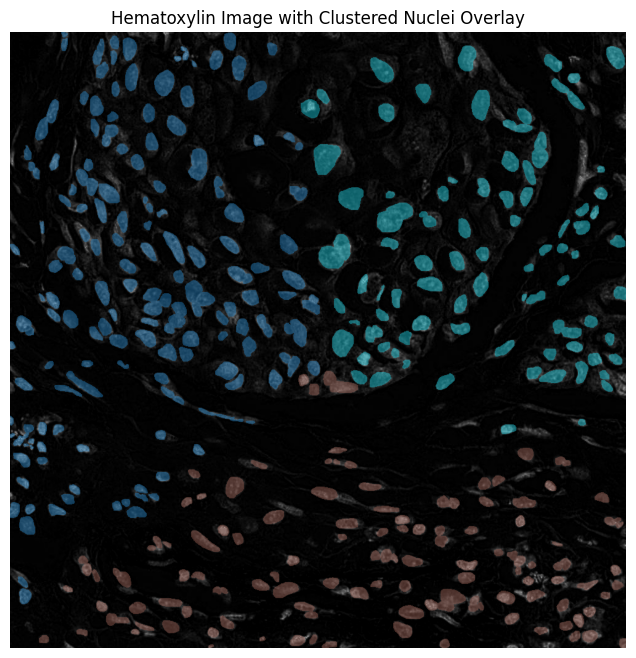

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.colors import ListedColormap

# cluster_img: nuclei mask image where each nucleus pixel value = cluster label (0 to n_clusters-1)
# labels_im: nuclei instance mask from connected components (values 0=background, 1,...=nuclei IDs)
# hematox_np: grayscale hematoxylin image

# Create RGB image from grayscale hematoxylin
hematox_rgb = cv2.cvtColor(hematox_np, cv2.COLOR_GRAY2RGB)

# Create color map for clusters
cluster_cmap = plt.cm.get_cmap('tab10', n_clusters)
cluster_colors = (cluster_cmap(np.arange(n_clusters))[:, :3] * 255).astype(np.uint8)

# Create overlay image
overlay = hematox_rgb.copy()

for i, cluster_label in enumerate(labels):
    # For all pixels belonging to this nucleus, color overlay with cluster color, with transparency
    nucleus_mask = (labels_im == i + 1)
    overlay[nucleus_mask] = (0.5 * hematox_rgb[nucleus_mask] + 0.5 * cluster_colors[cluster_label]).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.title('Hematoxylin Image with Clustered Nuclei Overlay')
plt.axis('off')
plt.show()


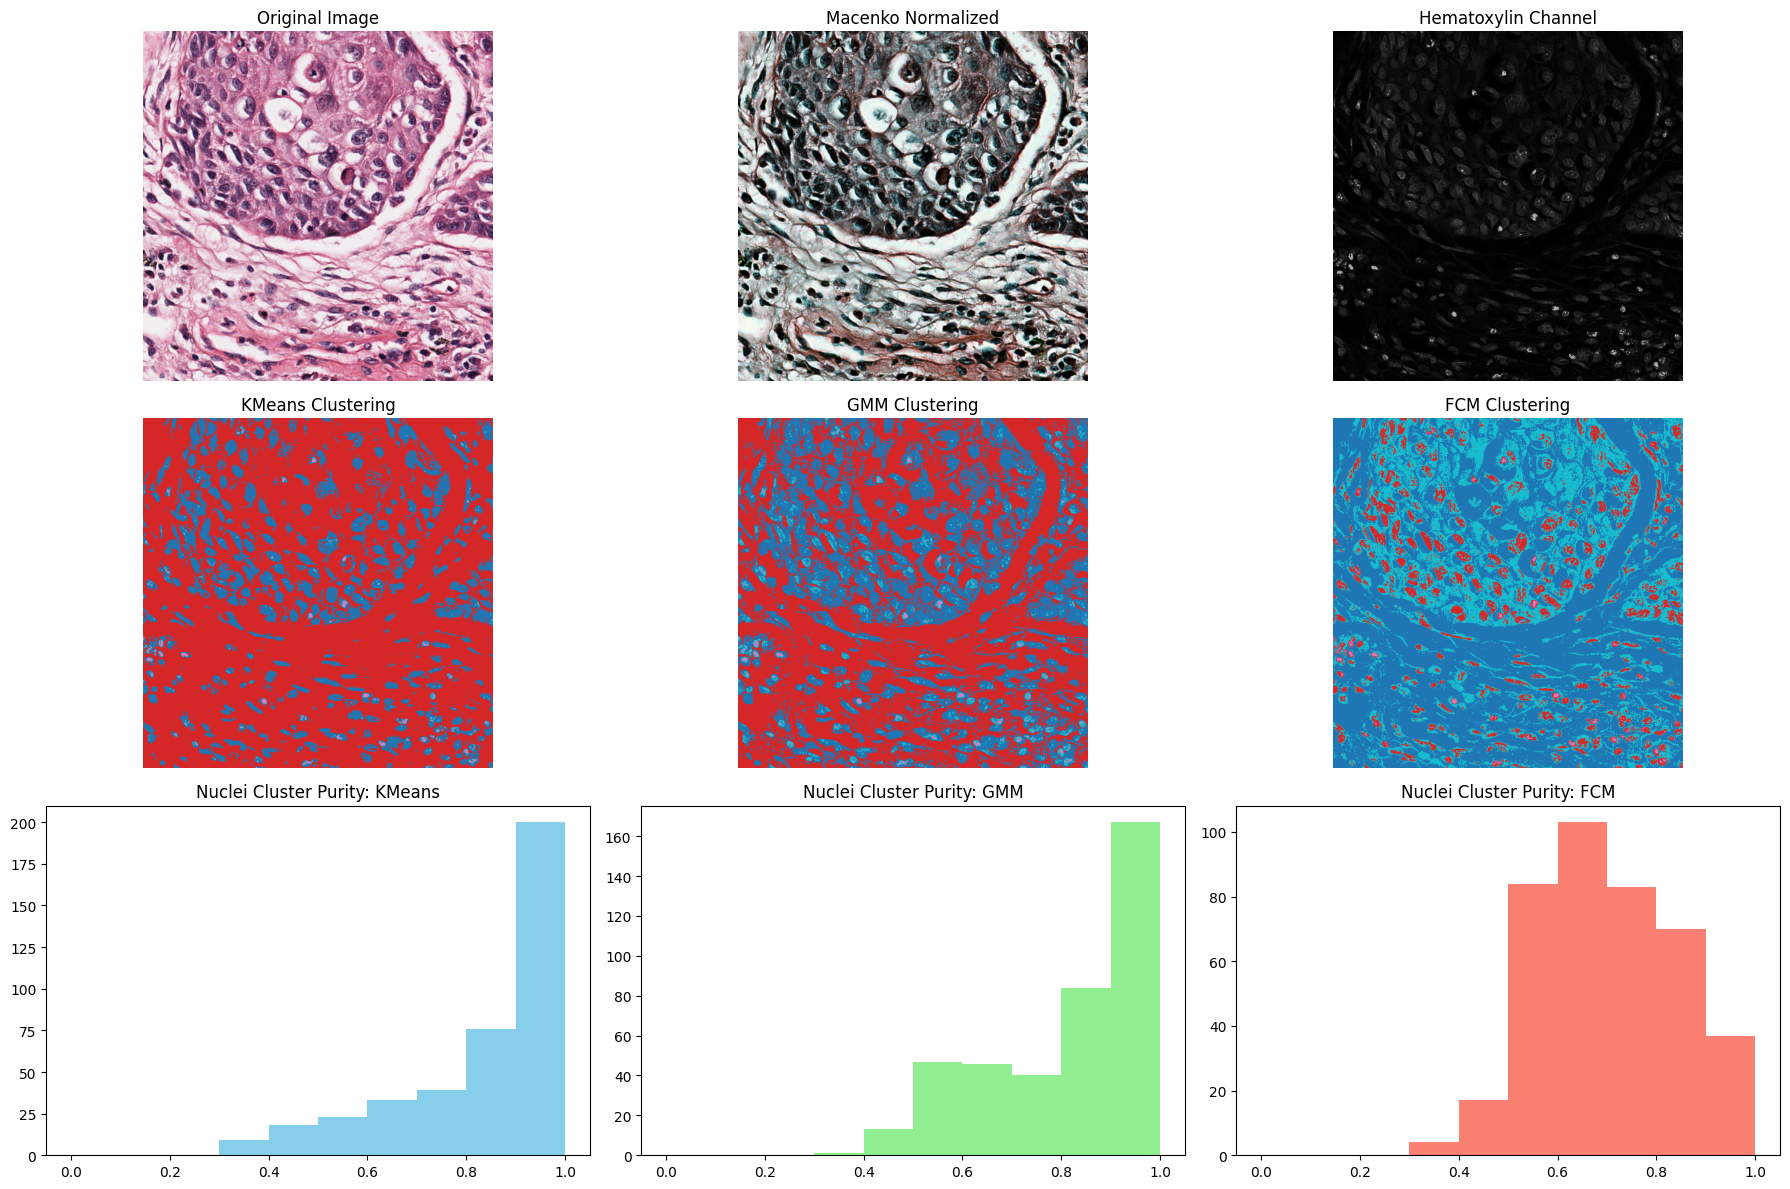

FileNotFoundError: [Errno 2] No such file or directory: 'phase2_kmeans_mask.npy'

In [1]:
# === PHASE 3: Nuclei-wise Feature Clustering and Evaluation ===

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from skimage.color import rgb2hed
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.filters import sobel
from skimage import exposure
from skfuzzy import cmeans
from collections import Counter

# === CONFIG ===
img_name = "TCGA-21-5784-01Z-00-DX1"
img_path = f"{img_name}.tif"
gt_mask_path = "gt_mask.png"
instance_mask_path = "instance_mask.png"
n_clusters = 4

# === Load Image and Masks ===
def load_image(path):
    img = tifffile.imread(path)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img[:, :, :3]

def load_mask(path):
    return np.array(Image.open(path))

image = load_image(img_path)
gt_mask = load_mask(gt_mask_path)
instance_mask = load_mask(instance_mask_path)

# === Step 1: Macenko Normalization (simplified) ===
def macenko_normalization(img):
    img = img.astype(np.float32) / 255.0
    img[:, :, 0] = exposure.equalize_hist(img[:, :, 0])
    img[:, :, 1] = exposure.equalize_hist(img[:, :, 1])
    img[:, :, 2] = exposure.equalize_hist(img[:, :, 2])
    return (img * 255).astype(np.uint8)

normalized_img = macenko_normalization(image)

# === Step 2: Extract H-stain (Hematoxylin) Channel ===
hed = rgb2hed(normalized_img / 255.0)
H_channel = hed[:, :, 0]

# === Step 3: Compute Sobel Edges for Texture ===
edges = sobel(H_channel)

# === Step 4: Feature Vector per Pixel ===
H_vec = H_channel.flatten()
edges_vec = edges.flatten()
features = np.stack([H_vec, edges_vec], axis=1)

# === Step 5: Apply Clustering ===
def cluster_kmeans(X, k):
    return KMeans(n_clusters=k, random_state=42).fit_predict(X)

def cluster_gmm(X, k):
    return GaussianMixture(n_components=k, random_state=42).fit_predict(X)

def cluster_fcm(X, k):
    data = X.T
    cntr, u, _, _, _, _, _ = cmeans(data, c=k, m=2, error=0.005, maxiter=1000)
    return np.argmax(u, axis=0)

H, W = H_channel.shape
kmeans_masked = cluster_kmeans(features, n_clusters).reshape(H, W)
gmm_masked = cluster_gmm(features, n_clusters).reshape(H, W)
fcm_masked = cluster_fcm(features, n_clusters).reshape(H, W)

# === Step 6: Dice Score Evaluation ===
def best_dice_per_cluster(pred_mask, gt_mask, n_clusters):
    dice_scores = []
    for i in range(1, n_clusters):
        pred = (pred_mask == i).astype(np.uint8)
        intersection = np.logical_and(pred, gt_mask).sum()
        dice = (2. * intersection) / (pred.sum() + gt_mask.sum() + 1e-8)
        dice_scores.append(dice)
    return dice_scores

dice_kmeans = best_dice_per_cluster(kmeans_masked, gt_mask, n_clusters)
dice_gmm = best_dice_per_cluster(gmm_masked, gt_mask, n_clusters)
dice_fcm = best_dice_per_cluster(fcm_masked, gt_mask, n_clusters)

# === Step 7: Nuclei-wise Cluster Purity ===
def cluster_purity_per_nucleus(cluster_map, instance_mask, min_size=10):
    instance_ids = np.unique(instance_mask)
    purities = []
    for inst_id in instance_ids:
        if inst_id == 0: continue
        coords = np.where(instance_mask == inst_id)
        if len(coords[0]) < min_size:
            continue
        cluster_labels = cluster_map[coords]
        label_counts = Counter(cluster_labels)
        dominant_label, count = label_counts.most_common(1)[0]
        purity = count / len(cluster_labels)
        purities.append(purity)
    return purities

purity_kmeans = cluster_purity_per_nucleus(kmeans_masked, instance_mask)
purity_gmm = cluster_purity_per_nucleus(gmm_masked, instance_mask)
purity_fcm = cluster_purity_per_nucleus(fcm_masked, instance_mask)

# === Step 8: Visualization ===
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

axs[0, 0].imshow(image)
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(normalized_img)
axs[0, 1].set_title("Macenko Normalized")

axs[0, 2].imshow(H_channel, cmap='gray')
axs[0, 2].set_title("Hematoxylin Channel")

axs[1, 0].imshow(kmeans_masked, cmap='tab10')
axs[1, 0].set_title("KMeans Clustering")
axs[1, 1].imshow(gmm_masked, cmap='tab10')
axs[1, 1].set_title("GMM Clustering")
axs[1, 2].imshow(fcm_masked, cmap='tab10')
axs[1, 2].set_title("FCM Clustering")

axs[2, 0].hist(purity_kmeans, bins=10, range=(0,1), color='skyblue')
axs[2, 0].set_title("Nuclei Cluster Purity: KMeans")
axs[2, 1].hist(purity_gmm, bins=10, range=(0,1), color='lightgreen')
axs[2, 1].set_title("Nuclei Cluster Purity: GMM")
axs[2, 2].hist(purity_fcm, bins=10, range=(0,1), color='salmon')
axs[2, 2].set_title("Nuclei Cluster Purity: FCM")

for ax in axs.flat:
    ax.axis('off') if ax.get_subplotspec().is_first_row() or "Purity" not in ax.get_title() else None

plt.tight_layout()
plt.show()

# ... [Your previous code up to visualization] ...

# === Step 8: Visualization with saving ===
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.patch.set_edgecolor('black')  # Add black border to figure
fig.patch.set_linewidth(1.5)

axs[0, 0].imshow(image)
axs[0, 0].set_title("Original Image", fontsize=12)

axs[0, 1].imshow(normalized_img)
axs[0, 1].set_title("Macenko Normalized", fontsize=12)

axs[0, 2].imshow(H_channel, cmap='gray')
axs[0, 2].set_title("Hematoxylin Channel", fontsize=12)

axs[1, 0].imshow(kmeans_masked, cmap='tab10')
axs[1, 0].set_title("KMeans Clustering", fontsize=12)

axs[1, 1].imshow(gmm_masked, cmap='tab10')
axs[1, 1].set_title("GMM Clustering", fontsize=12)

axs[1, 2].imshow(fcm_masked, cmap='tab10')
axs[1, 2].set_title("FCM Clustering", fontsize=12)

axs[2, 0].hist(purity_kmeans, bins=10, range=(0,1), color='skyblue')
axs[2, 0].set_title("Nuclei Purity: KMeans", fontsize=12)

axs[2, 1].hist(purity_gmm, bins=10, range=(0,1), color='lightgreen')
axs[2, 1].set_title("Nuclei Purity: GMM", fontsize=12)

axs[2, 2].hist(purity_fcm, bins=10, range=(0,1), color='salmon')
axs[2, 2].set_title("Nuclei Purity: FCM", fontsize=12)

for ax in axs.flat:
    # Hide axis ticks and labels for images (except histograms)
    if 'Purity' not in ax.get_title():
        ax.axis('off')

plt.tight_layout()
plt.savefig("phase3_clustering_visualization.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.close(fig)  # Close the figure after saving to free memory

# === Step 9: Phase 2 vs Phase 3 Dice Comparison (saving plot) ===
phase2_kmeans = np.load("phase2_kmeans_mask.npy")
phase2_gmm = np.load("phase2_gmm_mask.npy")
phase2_fcm = np.load("phase2_fcm_mask.npy")

phase2_scores = {
    "KMeans": max(best_dice_per_cluster(phase2_kmeans, gt_mask, n_clusters)),
    "GMM": max(best_dice_per_cluster(phase2_gmm, gt_mask, n_clusters)),
    "FCM": max(best_dice_per_cluster(phase2_fcm, gt_mask, n_clusters))
}

phase3_scores = {
    "KMeans": max(dice_kmeans),
    "GMM": max(dice_gmm),
    "FCM": max(dice_fcm)
}

labels = list(phase2_scores.keys())
x = np.arange(len(labels))
width = 0.35

fig2, ax2 = plt.subplots(figsize=(8, 5))
fig2.patch.set_edgecolor('black')
fig2.patch.set_linewidth(1.5)

ax2.bar(x - width/2, [phase2_scores[l] for l in labels], width, label="Phase 2", color="lightgray")
ax2.bar(x + width/2, [phase3_scores[l] for l in labels], width, label="Phase 3", color="mediumseagreen")

ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=12)
ax2.set_ylabel("Dice Score", fontsize=12)
ax2.set_title("Dice Score Comparison: Phase 2 vs Phase 3", fontsize=14)
ax2.legend(fontsize=12)





In [2]:
import matplotlib.pyplot as plt

# Function to save single image with title and border
def save_image(img, title, filename, cmap=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(1.5)
    if cmap:
        ax.imshow(img, cmap=cmap)
    else:
        ax.imshow(img)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

# Save Normalized image
save_image(normalized_img, "Macenko Normalized Image", "normalized_image.png")

# Save KMeans segmentation mask
save_image(kmeans_masked, "KMeans Segmentation", "kmeans_segmentation.png", cmap='tab10')

# Save FCM segmentation mask
save_image(fcm_masked, "FCM Segmentation", "fcm_segmentation.png", cmap='tab10')

# Save GMM segmentation mask
save_image(gmm_masked, "GMM Segmentation", "gmm_segmentation.png", cmap='tab10')
